In [1]:
import time

import pandas as pd
import seaborn as sns
from tqdm import tqdm

from synthflow.birth import COLUMN_WEIGHTS
from synthflow.evaluation import numerify
from synthflow.evaluation.faithfulness import _compute_beta

In [2]:
real_df = pd.read_csv("../data/real.csv")
real_df["date_of_birth"] = pd.to_datetime(real_df["date_of_birth"])
nreal_df = numerify(real_df)
assert (real_df["date_of_birth"].dt.dayofyear == nreal_df["date_of_birth"]).all()
nreal_df.head()

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
0,1.0,0.0,38.0,3163.0,1.0,1.0,41.0
1,1.0,0.0,30.0,3370.0,2.0,1.0,41.0
2,1.0,0.0,27.0,3335.0,1.0,1.0,41.0
3,1.0,1.0,33.0,3082.0,1.0,2.0,42.0
4,1.0,0.0,37.0,3138.0,3.0,1.0,43.0


In [3]:
synth_df = pd.read_pickle("../data/synth.pckl")
nsynth_df = numerify(synth_df)
nsynth_df.head()

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
0,344.0,0.0,29.0,3662.0,1.0,1.0,40.0
1,295.0,1.0,39.0,3132.0,1.0,1.0,42.0
2,246.0,0.0,35.0,3398.0,1.0,2.0,42.0
3,344.0,0.0,24.0,3398.0,1.0,2.0,41.0
4,344.0,0.0,35.0,3398.0,2.0,1.0,42.0


In [4]:
proc_df = pd.read_pickle("../data/proc.pckl")
nproc_df = numerify(proc_df)
nproc_df.head()

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
0,1.0,0.0,38.0,3163.0,1.0,1.0,41.0
1,1.0,0.0,30.0,3370.0,2.0,1.0,41.0
2,1.0,0.0,27.0,3335.0,1.0,1.0,41.0
3,1.0,1.0,33.0,3082.0,1.0,2.0,42.0
4,1.0,0.0,37.0,3138.0,3.0,1.0,42.0


In [5]:
nreal_df.describe().round(2)

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
count,148023.00,148023.0,148023.00,148023.00,148023.00,148023.00,148023.00
mean,181.94,0.5,29.99,3284.94,1.33,1.33,41.33
std,105.09,0.5,5.01,172.02,0.67,0.67,1.17
min,1.00,0.0,15.00,2311.00,1.00,1.00,37.00
25%,91.00,0.0,27.00,3171.00,1.00,1.00,41.00
50%,182.00,1.0,30.00,3288.00,1.00,1.00,41.00
75%,273.00,1.0,33.00,3402.00,1.00,1.00,42.00
max,364.00,1.0,53.00,3935.00,10.00,10.00,47.00


In [6]:
nsynth_df.describe().round(2)

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
count,148023.00,148023.0,148023.00,148023.00,148023.00,148023.00,148023.00
mean,178.87,0.5,30.05,3284.87,1.36,1.33,41.08
std,103.14,0.5,4.98,195.07,0.76,0.65,1.40
min,1.00,0.0,18.00,1012.00,1.00,1.00,24.00
25%,78.00,0.0,27.00,3132.00,1.00,1.00,41.00
50%,176.00,1.0,31.00,3398.00,1.00,1.00,41.00
75%,274.00,1.0,33.00,3398.00,2.00,2.00,42.00
max,344.00,1.0,48.00,4988.00,7.50,4.00,42.00


In [7]:
nproc_df.describe().round(2)

,date_of_birth,is_female,mother_age,weight,num_birth,plurality,gestation_week
count,148023.00,148023.0,148023.00,148023.00,148023.00,148023.00,148023.00
mean,181.95,0.5,30.00,3284.94,1.33,1.33,41.15
std,105.13,0.5,4.97,172.02,0.67,0.64,0.90
min,1.00,0.0,18.00,2311.00,1.00,1.00,37.00
25%,92.00,0.0,27.00,3171.00,1.00,1.00,41.00
50%,183.00,1.0,30.00,3288.00,1.00,1.00,41.00
75%,274.00,1.0,33.00,3402.00,1.00,1.00,42.00
max,365.00,1.0,50.00,3935.00,7.50,4.00,42.00


## Real thing

In [9]:
help(_compute_beta)

Help on function _compute_beta in module synthflow.evaluation.faithfulness:

_compute_beta(x: 'pd.DataFrame', y: 'pd.DataFrame', alpha: 'float', algorithm_candidates: 'list[tuple[str, int]]', column_weights: 'None | dict[str, float]' = None, p: 'float' = 1) -> 'tuple[float, float, str]'
    # TODO: refactor



In [10]:
TIMEOUT = 30 * 60  # 30 minutes


def run_trial(
    x,
    y,
    alpha,
    algorithm,
    n_records,
    column_weights=COLUMN_WEIGHTS,
    timeout=TIMEOUT,
    random_state=42,
):
    x = x.sample(n_records, random_state=random_state)
    y = y.sample(n_records, random_state=random_state)

    algorithm_candidates = [(algorithm, timeout)]

    return _compute_beta(x, y, alpha, algorithm_candidates, column_weights)

In [11]:
run_trial(nreal_df, nsynth_df, 0.5, "push_relabel", 100000, timeout=60)

(0.78609, 0.0001993039930399304, 'push_relabel')

In [12]:
LOAD_RESULTS = True
PATH = "faithfulness-algos-results.csv"

if LOAD_RESULTS:
    df = pd.read_csv(PATH)

else:
    results = []

    for n in tqdm([1000, 5000, 10000, 50000, 75000, 100000], desc="Number of Records"):
        for alpha in tqdm([0.8, 1, 1.5, 1.75], desc="ɑ"):
            for alg in tqdm(
                ["edmonds_karp", "hopcroft_karp", "push_relabel"], desc="Algorithm"
            ):
                if n >= 10000 and alg == "edmonds_karp":
                    continue

                start = time.time()
                beta, density, _, _ = run_trial(
                    nreal_df, nsynth_df, alpha, alg, n, timeout=TIMEOUT
                )
                end = time.time()
                duration = end - start

                result = (
                    alg,
                    duration,
                    alpha,
                    n,
                    beta,
                    density,
                    int(2 * density * n * (n - 1)),
                )
                results.append(result)

    df = pd.DataFrame(
        results,
        columns=["alg", "duration", "alpha", "n_records", "beta", "density", "n_edges"],
    )
    df = df.sort_values(["n_records", "alpha", "alg"]).reset_index(drop=True)
    df.to_csv(PATH, index=False)

In [13]:
df

,alg,duration,alpha,n_records,beta,density,n_edges
0,hopcroft_karp,0.071768,0.80,1000,0.791000,0.000837,1671
1,edmonds_karp,0.346573,0.80,1000,0.791000,0.000837,1671
2,push_relabel,0.091647,0.80,1000,0.791000,0.000837,1671
3,hopcroft_karp,0.084029,1.00,1000,0.679000,0.001648,3292
4,edmonds_karp,0.356443,1.00,1000,0.679000,0.001648,3292
5,push_relabel,0.093371,1.00,1000,0.679000,0.001648,3292
6,hopcroft_karp,0.099406,1.50,1000,0.390000,0.006086,12160
7,edmonds_karp,0.462007,1.50,1000,0.390000,0.006086,12160
8,push_relabel,0.113683,1.50,1000,0.390000,0.006086,12160
9,hopcroft_karp,0.388520,0.80,5000,0.622800,0.000800,40004


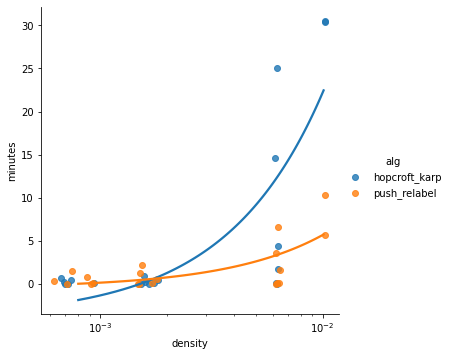

In [14]:
df["minutes"] = df["duration"] / 60
ax = sns.lmplot(
    x="density",
    y="minutes",
    hue="alg",
    data=df[df["alg"] != "edmonds_karp"],
    x_jitter=0.0002,
    ci=None,
)
ax.set(xscale="log")

# TODO: run it on random bipartite graphs to get a better heuristics
`graph_tool.Graph.Random_Bipartite()`